In [47]:
self = awg_spectrum

In [2]:
import pickle
from collections import OrderedDict

import numpy as np
import scipy.signal as sp

from core.configoption import ConfigOption
from core.module import Base
from core.util.modules import get_home_dir
from hardware.awg import SpectrumAWG35
from interface.microwave_interface import AWGLimits
from interface.pulser_interface import PulserInterface, PulserConstraints
from hardware.thirdparty.spectrum.pyspcm import *

### Function to load ensembles from memory for multi replay triggered mode

Can also just use the function in the qudi hardware file

In [49]:
def run_triggered_multi_from_list(seqs, memsize_seq=None):
        """
        seqs should have the 'waveform_ch1.pkl' form, i.e a list of waveform name saved on memory
        They should all be of equal length as far as I can understand. If not atleast the last should be the longest
        Single segment memory size determines how much is played after a trigger
        Eg: 
        ([
        ['sinA_a_ch0.pkl', 'sinA_a_ch1.pkl', 'sinA_d_ch1.pkl', 'sinA_d_ch1.pkl']
        ,['sinB_a_ch0.pkl', 'sinB_a_ch1.pkl', 'sinB_d_ch1.pkl', 'sinB_d_ch1.pkl']
        ],  'sinA_d_ch0.pkl')
        
        OR 
        
        ['sinA', 'sinB']
        """
        self.instance.set_mode('multi')       
        sample_rate = self.get_sample_rate()
        self.set_reps(0)
        path = self.waveform_folder
        wave_form_list = self.get_waveform_names()
        
        # these are .pkl file names from saved_pulsed_asseets which simply have everything that happens in a channel during the
        # entire ensmeble. Multiple ensembles can be sequenced into memory to play one after the other on receiving the trigger.
        def wfm_l_maker(ensemble_names=[]):
            wfm_l = []
            for iens, ens in enumerate(ensemble_names):
                l = [f'{ens}_a_ch{i}.pkl' for i in range(5)]
                wfm_l.append(l)
                l = [f'{ens}_d_ch{i}.pkl' for i in range(6)]
                wfm_l[iens].extend(l)
            return wfm_l
        
        if isinstance(seqs[0], str):
            seqs = wfm_l_maker(seqs)            
            
        # load ensemble to determine the sequence size. This will determine how much is played after one external
        # trigger. It is assumed that all the ensembles are of equal length.
        waveform = seqs[-1][-1] if memsize_seq is None else memsize_seq
        load_dict = dict()
        wave_name = waveform.rsplit('.pkl')[0]
        channel_num = int(wave_name.rsplit('_ch', 1)[1])
        # Map channel numbers to HW channel numbers
        if '_a_ch' not in waveform:
            channel = channel_num + 4
        else:
            channel = channel_num
        load_dict[channel] = wave_name

        if not load_dict:
            self.log.error('No data to send to AWG')
            return -1

        for ch, value in load_dict.items():
            if value in wave_form_list:
                wavefile = '{0}.pkl'.format(value)
                filepath = os.path.join(path, wavefile)
                data = self.my_load_dict(filepath)
            else:
                self.log.error('Cannot find waveform to send to AWG')
                return -1
        
        max_seq = data
        segment_size = int(len(max_seq))       
        while not segment_size % 32 == 0:
            segment_size += 1

        self.instance.set_segment_size(segment_size)
        self.instance.set_memory_size(segment_size * len(seqs))
        self.instance.init_ext_trigger()
        
        # setting of seqment size,i.e, replay length, and init of trigger done.
        
        # loading of the ensemble data, separating into channel .pkl files and then writing into data list done here
        # after data_list for entire ensemble is compiled, upload is done into AWG specifying the segment size
        # and also the index this particular segment occupies in memory.
        for iseq, seq in enumerate(seqs):
            data_list = list()
            for i in range(4):
                data_list.append(np.zeros(int(segment_size), np.int16))
            for i in range(6):
                data_list.append(np.zeros(int(segment_size), np.bool))
                
            load_dict = seq
            new_dict = dict()
            for waveform in load_dict:
                wave_name = waveform.rsplit('.pkl')[0]
                channel_num = int(wave_name.rsplit('_ch', 1)[1])
                if '_a_ch' not in waveform:
                    channel = channel_num + 4
                else:
                    channel = channel_num
                new_dict[channel] = wave_name
            load_dict = new_dict

            if not load_dict:
                self.log.error('No data to send to AWG')
                return -1

            for ch, value in load_dict.items():
                if value in wave_form_list:
                    wavefile = '{0}.pkl'.format(value)
                    filepath = os.path.join(path, wavefile)
                    data = self.my_load_dict(filepath)
                    data_list[ch] = data
                    data_size = len(data)

                    if '_a_ch' in value:
                        chan_name = 'a_ch{0}'.format(value.rsplit('a_ch')[1])
                        self.loaded_assets[chan_name] = value[:-6]
                    else:
                        chan_name = 'd_ch{0}'.format(value.rsplit('d_ch')[1])
                        self.loaded_assets[chan_name] = value[:-6]
                else:
                    self.log.warn('Waveform {} not found in {}'.format(value, self.waveform_folder))
                    data_size = 0

            # See pg 130 in manual
            count = 0
            while not data_size % 32 == 0:
                data_size += 1
                count += 1
            if not count == 1:
                extra = np.zeros(count, np.int16)
                new_list = list()
                for row in data_list:
                    new_row = np.concatenate((row, extra), axis=0)
                    new_list.append(new_row)
                data_list = new_list

            self.log.info(f'Uploading waveform set {seq} to AWG...')
            if not data_size == 0:
                self.instance.upload(data_list, segment_size, segment_size * iseq)
                self.typeloaded = 'waveform'
        self.log.info('Upload to AWG complete')

        del seqs

## Functions to load DC and Sine test signals

In [2]:
from logic.pulsed.sampling_functions import SamplingFunctions as SF
import logic.pulsed.pulse_objects as po

In [22]:
def load_sine(channels = [{'name': 'a_ch0', 'amp': 1.00, 'freq': 1e6, 'phase': 0.00}], dur=1e-6, identifier=''):
    """
    Load a sine waveform to be played simultaneously on the specified channels.
    """
    ele = []
    a_ch = {'a_ch0': SF.DC(0), 'a_ch1': SF.DC(0), 'a_ch2': SF.DC(0), 'a_ch3': SF.DC(0)}
    d_ch = {'d_ch0': False, 'd_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False}
    for ch in channels:
        a_ch[ch['name']] = SF.Sin(amplitude=ch['amp'], frequency=ch['freq'], phase=ch['phase'])
        
    ele.append(po.PulseBlockElement(init_length_s=dur,  pulse_function=a_ch, digital_high=d_ch))
    pulse_block = po.PulseBlock(name=f'SinAuto', element_list=ele)
    sequencegeneratorlogic_AWG.save_block(pulse_block)

    block_list = []
    block_list.append((pulse_block.name, 0))
    auto_pulse_CW = po.PulseBlockEnsemble(f'SinAuto{identifier}', block_list)

    ensemble = auto_pulse_CW
    ensemblename = auto_pulse_CW.name
    sequencegeneratorlogic_AWG.save_ensemble(ensemble)
    sequencegeneratorlogic_AWG.sample_pulse_block_ensemble(ensemblename)
    sequencegeneratorlogic_AWG.load_ensemble(ensemblename)

In [41]:
def load_dc(channels = [{'name': 'a_ch0', 'amp': 1.00}], dur=1e-6, identifier=''):
    """
    Load a sine waveform to be played simultaneously on the specified channels.
    """
    ele = []
    a_ch = {'a_ch0': SF.DC(0), 'a_ch1': SF.DC(0), 'a_ch2': SF.DC(0), 'a_ch3': SF.DC(0)}
    d_ch = {'d_ch0': False, 'd_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False}
    for ch in channels:
        a_ch[ch['name']] = SF.DC(ch['amp'])
        
    ele.append(po.PulseBlockElement(init_length_s=dur,  pulse_function=a_ch, digital_high=d_ch))
    pulse_block = po.PulseBlock(name=f'DCAuto', element_list=ele)
    sequencegeneratorlogic_AWG.save_block(pulse_block)

    block_list = []
    block_list.append((pulse_block.name, 0))
    auto_pulse_CW = po.PulseBlockEnsemble(f'DCAuto{identifier}', block_list)

    ensemble = auto_pulse_CW
    ensemblename = auto_pulse_CW.name
    sequencegeneratorlogic_AWG.save_ensemble(ensemble)
    sequencegeneratorlogic_AWG.sample_pulse_block_ensemble(ensemblename)
    sequencegeneratorlogic_AWG.load_ensemble(ensemblename)

## Run triggered DC and Sine test signals

In [123]:
awg_spectrum.pulser_off()
a_amp = 1.00
b_amp = a_amp * 0.99

ch = [
    {'name': 'a_ch0', 'amp': a_amp, 'freq': 100e6, 'phase': 0.00},
    {'name': 'a_ch1', 'amp': b_amp, 'freq': 100e6, 'phase': 90.00}
    ]
load_sine(channels = ch, dur = 100e-6, identifier = 'A')

ch = [
    {'name': 'a_ch0', 'amp': a_amp, 'freq': 100e6, 'phase': 90.00},
    {'name': 'a_ch1', 'amp': b_amp, 'freq': 100e6, 'phase': 0.00}
    ]
load_sine(channels = ch, dur = 100e-6, identifier = 'B')

In [188]:
awg_spectrum.pulser_off()
amp = 2
ch = [
    {'name': 'a_ch0', 'amp': amp},
    {'name': 'a_ch1', 'amp': amp}
    ]
load_dc(channels = ch, dur = 100e-6, identifier = 'A')

ch = [
    {'name': 'a_ch0', 'amp': amp},
    {'name': 'a_ch1', 'amp': amp}
    ]
load_dc(channels = ch, dur = 100e-6, identifier = 'B')

In [124]:
awg_spectrum.pulser_off()
awg_spectrum.load_triggered_multi_replay(['SinAutoA', 'SinAutoB'])
awg_spectrum.pulser_on()

1

In [189]:
awg_spectrum.pulser_off()
awg_spectrum.load_triggered_multi_replay(['DCAutoA', 'DCAutoB'])
awg_spectrum.pulser_on()

1

In [372]:
awg_spectrum.pulser_off()

1

In [376]:
pulsedmasterlogic_AWG.pulsedmeasurementlogic().pulsegenerator()

# MW Source - LO - CW control

In [350]:
mw_source_smbv.set_cw(frequency=2e9, power=5)
mw_source_smbv.cw_on()

0

In [373]:
mw_source_smbv.off()

0

In [257]:
awg_spectrum.pulser_off()
a_amp = 2
b_amp = a_amp * 1

a_phase = 90
b_phase = 0

ch = [
    {'name': 'a_ch0', 'amp': a_amp, 'freq': 100e6, 'phase': a_phase},
    {'name': 'a_ch1', 'amp': b_amp, 'freq': 100e6, 'phase': b_phase}
    ]
load_sine(channels = ch, dur = 100e-6, identifier = 'A')

awg_spectrum.pulser_off()
awg_spectrum.load_triggered_multi_replay(['SinAutoA'])
awg_spectrum.pulser_on()

1

# Regular pulsing - no triggering necessary

In [370]:
awg_spectrum.pulser_off()
awg_spectrum.instance.init_all_channels()
a_amp = 1
b_amp = a_amp *1.2

a_phase = 0
b_phase = 100

# a_phase = 100
# b_phase = 0

ch = [
    {'name': 'a_ch0', 'amp': a_amp, 'freq': 20e6, 'phase': a_phase},
    {'name': 'a_ch1', 'amp': b_amp, 'freq': 20e6, 'phase': b_phase}
    ]
load_sine(channels = ch, dur = 100e-6, identifier = 'A')

awg_spectrum.pulser_on()

1

In [377]:
awg_spectrum.pulser_off()
awg_spectrum.instance.init_all_channels()
amp = 1
ch = [
    {'name': 'a_ch0', 'amp': amp},
    {'name': 'a_ch1', 'amp': amp*1.2}
    ]
load_dc(channels = ch, dur = 100e-6, identifier = 'A')

awg_spectrum.pulser_on()

1

# AWG sequence mode tests

In [ ]:
def load_sequence_segment(self, seqs, memsize_seq=None, segment_index=0):
    """
    seqs should have the 'waveform_ch1.pkl' form, i.e a list of waveform name saved on memory
    They should all be of equal length as far as I can understand. If not atleast the last should be the longest
    Single segment memory size determines how much is played after a trigger
    Eg: 
    ([
    ['sinA_a_ch0.pkl', 'sinA_a_ch1.pkl', 'sinA_d_ch1.pkl', 'sinA_d_ch1.pkl']
    ,['sinB_a_ch0.pkl', 'sinB_a_ch1.pkl', 'sinB_d_ch1.pkl', 'sinB_d_ch1.pkl']
    ],  'sinA_d_ch0.pkl')

    OR 

    ['sinA', 'sinB']
    """
    
    path = self.waveform_folder
    wave_form_list = self.get_waveform_names()

    # these are .pkl file names from saved_pulsed_assets which simply have everything that happens in a channel during the
    # entire ensmeble. Multiple ensembles can be sequenced into memory to play one after the other on receiving the trigger.
    def wfm_l_maker(ensemble_names=[]):
        wfm_l = []
        for iens, ens in enumerate(ensemble_names):
            l = [f'{ens}_a_ch{i}.pkl' for i in range(5)]
            wfm_l.append(l)
            l = [f'{ens}_d_ch{i}.pkl' for i in range(6)]
            wfm_l[iens].extend(l)
        return wfm_l
    if len(seqs)>1:
        self.log.warning('Attempting to load multiple ensembles into one segement memory. Please load one ensemble into one segment!')
        return -1
    if isinstance(seqs[0], str):
        seqs = wfm_l_maker(seqs)            

    # load ensemble to determine the sequence size. This will determine how much is played after one external
    # trigger. It is assumed that all the ensembles are of equal length.
    waveform = seqs[-1][-1] if memsize_seq is None else memsize_seq
    load_dict = dict()
    wave_name = waveform.rsplit('.pkl')[0]
    channel_num = int(wave_name.rsplit('_ch', 1)[1])
    # Map channel numbers to HW channel numbers
    if '_a_ch' not in waveform:
        channel = channel_num + 4
    else:
        channel = channel_num
    load_dict[channel] = wave_name

    if not load_dict:
        self.log.error('No data to send to AWG')
        return -1

    for ch, value in load_dict.items():
        if value in wave_form_list:
            wavefile = '{0}.pkl'.format(value)
            filepath = os.path.join(path, wavefile)
            data = self.my_load_dict(filepath)
        else:
            self.log.error('Cannot find waveform to send to AWG')
            return -1

    max_seq = data
    segment_size = int(len(max_seq))       
    while not segment_size % 32 == 0:
        segment_size += 1

    self.instance.set_current_segment(segment_index)
    self.instance.set_memory_size(segment_size, True) #This will set the memory size of the single segment at segement_index
    # setting of seqment size,i.e, replay length, and init of trigger done.

    # loading of the ensemble data, separating into channel .pkl files and then writing into data list done here
    # after data_list for entire ensemble is compiled, upload is done into AWG specifying the segment size
    # and also the index this particular segment occupies in memory.
    for iseq, seq in enumerate(seqs):
        data_list = list()
        for i in range(4):
            data_list.append(np.zeros(int(segment_size), np.int16))
        for i in range(6):
            data_list.append(np.zeros(int(segment_size), np.bool))

        load_dict = seq
        new_dict = dict()
        for waveform in load_dict:
            wave_name = waveform.rsplit('.pkl')[0]
            channel_num = int(wave_name.rsplit('_ch', 1)[1])
            if '_a_ch' not in waveform:
                channel = channel_num + 4
            else:
                channel = channel_num
            new_dict[channel] = wave_name
        load_dict = new_dict

        if not load_dict:
            self.log.error('No data to send to AWG')
            return -1

        for ch, value in load_dict.items():
            if value in wave_form_list:
                wavefile = '{0}.pkl'.format(value)
                filepath = os.path.join(path, wavefile)
                data = self.my_load_dict(filepath)
                data_list[ch] = data
                data_size = len(data)

                if '_a_ch' in value:
                    chan_name = 'a_ch{0}'.format(value.rsplit('a_ch')[1])
                    self.loaded_assets[chan_name] = value[:-6]
                else:
                    chan_name = 'd_ch{0}'.format(value.rsplit('d_ch')[1])
                    self.loaded_assets[chan_name] = value[:-6]
            else:
                self.log.warn('Waveform {} not found in {}'.format(value, self.waveform_folder))
                data_size = 0

        # See pg 130 in manual
        count = 0
        while not data_size % 32 == 0:
            data_size += 1
            count += 1
        if count>0:
            extra = np.zeros(count, np.int16)
            new_list = list()
            for row in data_list:
                new_row = np.concatenate((row, extra), axis=0)
                new_list.append(new_row)
            data_list = new_list

        # self.log.info(f'Uploading waveform set {seq} to AWG...')
        if not data_size == 0:
            self.instance.upload(data_list, segment_size, segment_size * iseq, True, True) #First flag is is_buffered, second is is_sequence_segment
            self.typeloaded = 'waveform'
    if self.print_log_info:
        self.log.info('Upload to AWG complete')
    del seqs
    
def load_ready_sequence_mode(self, sequence_step_list):
    """
    This function will load and ready the card with a supplied sequence given a sequence step list of the 
    following format:
    
    sequence_step_list = [
    {step_index = 0,
    step_segment = 'name_of_ensemble',
    step_loops = 10,
    next_step_index = 1,
    step_end_cond = 'always'
    }, .....
    
    {step_index = 10,
    step_segment = 'name_of_ensemble',
    step_loops = 1,
    next_step_index = 11,
    step_end_cond = 'always'
    }
                        ]
                        
    step_end_cond can be 'always', 'on_trig', 'stop'
    """
    def find_unique_segments(sequence_step_list):
        """Convenience function to find unique segments in sequence step
        """
        segments = []
        for step in sequence_step_list:
            segments.append(step['step_segment'])
        segments = list(set(segments)) # gives only the unique items
        segment_and_index = {}
        for index, seg in enumerate(segments):
            segment_and_index[seg] = index
        return segment_and_index, segments
    
    segment_and_index, segments = find_unique_segments(sequence_step_list)
    self.instance.init_sequence_mode(len(segments))
    
    for iseg, seg in enumerate(segments):
        self.load_sequence_segment(seqs=[seg], memsize_seq=None, segment_index=segment_and_index[seg])
            
    for istep, step in enumerate(sequence_step_list):
        step_index = step['step_index']
        mem_segment_index = segment_and_index[step['step_segment']]
        loops = step['step_loops']
        goto = step['next_step_index']
        next_condition = step['step_end_cond']
        self.instance.write_sequence_step(self, step_index, mem_segment_index, loops, goto, next_condition)
        
    

## Code for sequence mode trigger tests

In [2]:
#measurement parameters
laser_power_volatge = 0.08
pi_pulse = 69e-9 

#Driving information for the first LO (SMBV)
target_freq_0 = 200e6
LO_freq_0 = target_freq_0 + 100e6
power_0 = -20


#Driving information for the second LO (SGS)
target_freq_1 = 200e6
LO_freq_1 = target_freq_1 + 100e6
power_1 = -100#-20.7

tau_start = 0
tau_stop = 200e-9
tau_num = 30

self = pulsedjupyterlogic_AWG
pjl = pulsedjupyterlogic_AWG

pjl.initialize_ensemble(laser_power_volatge = laser_power_volatge, pi_pulse=pi_pulse, LO_freq_0=LO_freq_0, target_freq_0=target_freq_0, power_0=power_0, LO_freq_1=LO_freq_1, target_freq_1=target_freq_1, power_1=power_1)
sample_load_ready_AWG_for_special(self, LO_freq_0, 1e6, 1, pi_pulse)


(['Jupyter-ensemble-trig', 'Jupyter-ensemble-meas'], [{'step_index': 0, 'step_segment': 'Jupyter-ensemble-trig', 'step_loops': 1, 'next_step_index': 0, 'step_end_cond': 'always'}, {'step_index': 1, 'step_segment': 'Jupyter-ensemble-meas', 'step_loops': 1, 'next_step_index': 1, 'step_end_cond': 'always'}])

In [1]:
def sample_load_ready_AWG_for_special(self, LO_freq, delta_freq, repetitions, pi_duration):
    """Function to loop through the PhaseDuration list defined with ElementPS/AWG for each measurement.
        A list of all these small steps are made into an ensemble by load_large_sine_seq and is ready to be 
        played by trigger.
        One big ensemble covering the entire tau sweep that is triggered once before every sweep. Not before every tau instance.
    """
    def make_segment_block():
        large_seq = []

        for Element in self.BlockAWG:
            phase_0, phase_1, duration, user_MW_0_true, user_MW_1_true, freq_0, freq_1, channels = Element
            delta_0 = abs(self.LO_freq_0 - self.target_freq_0) if freq_0 is None else freq_0
            delta_1 = abs(self.LO_freq_1 - self.target_freq_1) if freq_1 is None else freq_1

            seq_part = {'channel_info' : [
                {'name': 'a_ch0', 'amp': 0.5 if user_MW_0_true else 0.0, 'freq': delta_0, 'phase': 0+phase_0},
                {'name': 'a_ch1', 'amp': 0.5 if user_MW_0_true else 0.0, 'freq': delta_0, 'phase': 100+phase_0},
                {'name': 'a_ch2', 'amp': 0.5 if user_MW_1_true else 0.0, 'freq': delta_1, 'phase': 0+phase_1},
                {'name': 'a_ch3', 'amp': 0.5 if user_MW_1_true else 0.0, 'freq': delta_1, 'phase': 100+phase_1}],
                'duration' : duration}
            for ch in channels:
                seq_part['channel_info'].append({'name': self.channel_names_AWG[ch], 'high': channels[ch]})
            large_seq.append(seq_part)
        return large_seq

    self.AWG_MW_reset()

    #################################################################################
    #Create large pulse block for the AWG
    explicit_steps_list = []
    ensemble_list_raw = []
    names = ["trig", "meas"] #importan to define the names of sequence segments

    #Create pulse sequence for the AWG - trigger in block
    self.BlockAWG = []
    #Trigger waiting block
    self.ElementAWG(channels={'MW_0':True, 'MW_1':True}, length=1e-6, freq_0=1e6, freq_1=1e6)
    ensemble_list_raw.append(make_segment_block())
    explicit_steps_list.append({"step_index" : 0,
                "step_segment" : "Jupyter-ensemble-"+names[0],
                "step_loops" : 1,
                "next_step_index" : 0,
                "step_end_cond" : 'always'
                })

    #Create pulse sequence for the AWG - measurement block
    self.BlockAWG = []

    #Break after Initalisation/read out
#     self.ElementAWG(channels={}, length=self.laser_waiting_time) 
    #Pi pulse - reference
    self.ElementAWG(channels={'MW_0':True, 'MW_1':True}, length=1e-6, freq_0=10e6, freq_1=10e6)
    ensemble_list_raw.append(make_segment_block())
    explicit_steps_list.append({"step_index" : 1,
                "step_segment" : "Jupyter-ensemble-"+names[1],
                "step_loops" : repetitions,
                "next_step_index" : 1,
                "step_end_cond" : 'always'
                })
    #################################################################################

    self.debug_ensemble_list_raw = ensemble_list_raw
    ensemble_list = self.load_ensembles(large_seq=ensemble_list_raw, identifier=names)
    self.debug_ensemble_list = ensemble_list
    sequence_step_list = explicit_steps_list
    self.debug_sequence_step_list = sequence_step_list
    self.AWG.load_ready_sequence_mode(sequence_step_list)
    return ensemble_list, sequence_step_list

In [38]:
load = awg_spectrum.my_load_dict
import matplotlib.pyplot as plt

In [43]:
file = "C:\\Users\\yy3\\saved_pulsed_assets\\waveform\\Jupyter-ensemble-meas_a_ch0.pkl"
data = load(file)

In [46]:
len(data)

625

In [50]:
1/1.25e9 * 31

2.48e-08

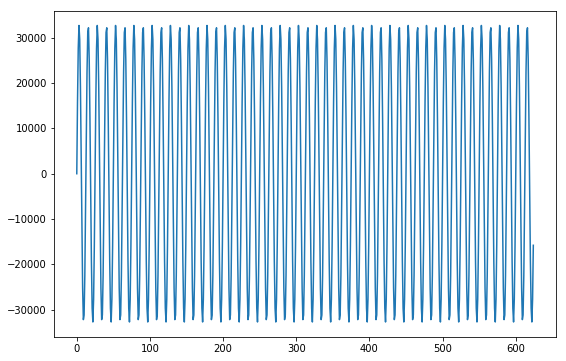

In [49]:
plt.plot(data)
plt.show()